<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: Котенков Игорь (@stalkermustang)

<center> 
### Оптимизация параметров с помощью hyperopt


Столкнувшись с оптимизацией гиперпараметров моделей в hw8 и почитав слак, я понял, что столь немаловажный аспект практически не затронут в курсе и вызывает немало вопросов. Чтож, давайте исправим ситуацию и окунемся в чудесный многомерный мир пространств параметров. <br/>
Для воспроизведения кода понадобится установить библиотеку hyperopt. Остальное за нас подготовили создатели пакета Anaconda.
Итак,

In [ ]:
!pip install hyperopt

In [74]:
#необходимые импорты
from hyperopt import fmin, tpe, rand, hp, STATUS_OK, Trials
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split

%matplotlib inline

## Вводные

Думаю, все знают, для чего мы перебираем комбинации (или "тюним" модель) параметров - значения по умолчанию, а так же эмпирические догадки практически всегда не дают желаемой/оптимальной точности, показывают далеко не лучшие результаты в соревнованиях и проде. Пример из жизни, который многим проходящим курс ODS будет близок - 8-ая домашка. Vowpal Wabbit без конкретных параметров показывал ужасную оценку(на секунду я даже подумал, что не смогу получить баллы) - больше 1.15 MAE(целевая метка - для тех, кто не в курсе, логарифмирована). Однако даже без добавления фич простой оптимизацией за 30 минут нашлось решение, побившее установленный бенчмарк(около 0.90 MAE).

С целью уменьшения количества итераций и времени перебора конфигураций были придуманы адаптивные байесовские методы. Они, в отличие от простого GridSearch(который работает в дискретном пространстве и имеет шанс пропустить оптимум, лежащий между ячейками сетки, как в примере ниже. Даже RandomSearch будет лучше), берут следующее приближение и вычисляют в нем значение функции опираясь на предыдущие проверки. Концепция заключается в нахождении некоторого баланса между поиском более удачных комбинаций около уже известных "хороших" точек и проверкой значений в неизведанных областях, где с ненулевой вероятностью могут находиться решения получше. Мне встречалось обозначение "learning vs earning" или "дилеммой explore-exploit" - можете блеснуть знаниями в кругу друзей или на митапе: обилие иностранных слов и терминов может даже помочь в трудоустройстве без собеседования(шутка - никогда не стоит говорить о том, в чем сам не разобрался. Перед использованием прогуглить). <br/>
Данная методика позволяет сходиться к более удачным решениям и за более короткий срок(ведь на больших датасетах прогон одной модели может обходитсья достаточно дорого в разрезе вычислительных мощностей). <br/>


<img src='http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2015/07/scikitlearn8.jpeg'>

В данной библиотеке реализован интересный аглоритм для оптимизации TPE, или Tree-Structured Parzen Estimators. Подробно с ним можно ознакомиться [по ссылке](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf). Если коротко, то TPE берет некоторое пространство поиска с разными плотнотями вероятностей и накладывает на них нормальное(Гауссовское) распределение со смещением, равным координатам новой точки. 

## К столу, джентльмены

Основным оружием в арсенале Hyperopt'a является функция fmin(первая в импортах). Она принимает в себя функцию(с несколькими аргументами, имеющими значения по умолчанию) и возвращает оптимальные параметры, с которыми значение функции минимально(если вам надо максимизировать, то очевидно, что нужно сменить знак вашей функции на противоположный). Подробнее об аргументах:
* Функция, которую надо минимизировать
* Пространство поиска параметров
* Объект для хранения истории поиска
* Алгоритм поиска


Тот самый алгоритм поиска TPE можно заменить при желании на RandomSearch. Достаточно указать 
```python
algo=hyperopt.tpe.suggest 
```
или
```python
algo=hyperopt.random.suggest
```

Неоспоримый плюс TPE в том, что он может работать со странными и непонятными пространствами: пусть один гиперпараметр непрерывный, другой дискретный, иной и вовсе категориальный. Не обязательно даже, чтобы данная комбинация имела хоть какой то смысл. 



Пространство поиска тоже задается весьма легко. Нужно всего лишь указать тип распределения и его границы. Приведу тут основные типы, с остальными можно ознакомиться в репозитории самой библиотеки.
```python
hp.choice() #равновероятный выбор из множества
hp.randint() #случайное целое число; random seed, например, т.к. нет корреляции между разноудаленными значениями
hp.uniform() #равномерное непрерывное распределение
hp.normal() #нормальное непрерывное распределение
hp.lognormal() #логнормальное непрерывное распределение
```

Тут есть интересный трюк: можно перебирать не только параметры модели, но и сами модели. Однако не вижу смысла на нем останавливаться, так как обычно данные готовятся под конкретную модель; однако ж все таки можно упороться, сделать для каждой свои преобразования, фичи, как описывает пайплайны один из туториалов, смешать в одно и оставить считаться на ночь(главное ошибку глупую не допустить, кхе, были прецеденты). Вот простой пример:
```python
space = hp.choice('classifier_type', [
    {
        'type': 'naive_bayes',
    },
    {
        'type': 'svm',
        'C': hp.lognormal('svm_C', 0, 1),
        'kernel': hp.choice('svm_kernel', [
            {'ktype': 'linear'},
            {'ktype': 'RBF', 'width': hp.lognormal('svm_rbf_width', 0, 1)},
            ]),
    },
    {
        'type': 'dtree',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth',
            [None, hp.qlognormal('dtree_max_depth_int', 3, 1, 1)]),
    },
    ])
```

И да, можно сделать ТОТ САМЫЙ *AutoML* :)

"Объект для хранения истории поиска", он же Trials, позволяет нам сохранять и переносить, а так же прерывать и продолжать процесс перебора и поиска гиперпараматров. Очень удобно, кстати  - новый создаем командой
```Python
trials = Trials()
```
, а если захотим продолжить со старого места(скажем, накинуть еще 100 итераций или же если остановили kernel, так как подумали, что соверишили ошибку/любая другая ситуация), то просто не будем пересоздавать объект, а укажем старый объект аргументом вызываемой функции *fmin*
```Python
best = fmin(objective,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)
```

Здесь стоит отметить, что прерывать поиск раньше заданного количества итераций не стоит. Это объясняется тем, что при поиске и выборе новых точек для проверки одним из критериев как раз и выступает оставшийся "баланс" проверок(эволюций). Сначала пространство замеряется в разных точках(условно бьется), а затем уточняется. Поэтому *trials* могут стать вашими друзьями. Вместе с этим они хранят все результаты вычисления заданной функции и статусы выполнения(можно отлавливать ошибки). 
<br/>Поставили на ночь перебор, утром остановили, сделали pickle, ушли на работу, вернулись и продолжили перебор после загрузки trials. Вещь!

И, наконец, самое главное. Сама функция для оптимизации. Она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции и, по желанию, статус. Простой пример
```Python
def objective(x):
    return {'loss': x ** 2, 'status': STATUS_OK }
```
, где STATUS_OK - объект, импортированный нами в начале(см. импорты). 

Посмотрим на игрушечный пример(они нагляднее и понятнее всего, чего уж спорить) и сравним random и tpe.

In [19]:
#зададим пространство поиска
space = [hp.uniform('x', -5, 5), hp.normal('y', -2, 2)] 

#укажем objective-функцию
def f(args):
    x, y = args
    return (x+2)**2+y**2-1

best = fmin(f, space, algo = tpe.suggest, max_evals=100)
print ('TPE result: ', best)

best = fmin(f, space, algo = rand.suggest, max_evals=100)
print ('random result: ', best)

TPE result:  {'y': -0.11503507195629692, 'x': -1.9934579852938588}
random result:  {'y': -0.3381348713133656, 'x': -2.1531518967001197}


Тут очевидно, что оптимум достигается в точке (-2.0; 0). Наиболее подходящую комбинацию аргументов (где дотигается минимальное значение функции) нашел именно TPE. То же применимо и к сложным многомерным структурам. <br/> Более того - предположим, что функция имеет локальные минимумы. При неудачном начальном приближении градиентный спуск не может выбраться из низины без использования специальных техник. Посмотрим, что сможет показать Hyperopt.

In [61]:
def f(args):
    x = args
    if x>=3:
        return (x-8.3)**2
    else:
        return (x+2)**2+3

TPE result:  {'x': 8.303668066801805}
random result:  {'x': -1.971406175338526}


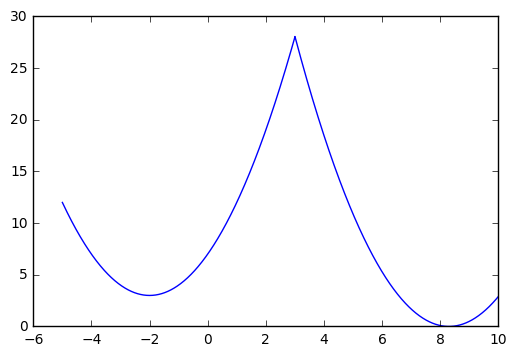

In [86]:
x = np.linspace(-5, 10, 1000)
y = [f(i) for i in x]

plt.plot(x, y);

space = hp.normal('x', -10, 10)

best = fmin(f, space, algo = tpe.suggest, max_evals=50)
print ('TPE result: ', best)

best = fmin(f, space, algo = rand.suggest, max_evals=50)
print ('random result: ', best)

Любое начальное приближение x < 3 давало бы другой оптимум в разрезе градиентного спуска. <br/>
Удивляет и RandomSearch - он так же попался на уловку. Правда, для этого пришлось снизить количество итераций. 

## Заключение
Hyperopt - мощное средство в руках умелого Data Scientist'a. Данная библиотека наиболее точно оценивает оптимальные параметры для заданных моделей, позволяет улучшать их результаты. С умным алгоритмом оптимизации TPE/байесовской оптимизацией ей не страшны локальные минимумы, ловушки разрывных распределений(причем, любых) и прочие узкие места остальных алгоритмов. 